In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(0)
epochs = 200
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [5]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [6]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [7]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [8]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [9]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [10]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [11]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [13]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-12 17:09:08,429 [DEBUG] kashgari - ------------------------------------------------
2020-12-12 17:09:08,429 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-12 17:09:08,430 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-12 17:09:08,430 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-12 17:09:08,430 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-12 17:09:08,431 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/200
47/47 [==============================] - 36s 772ms/step - loss: 1.9381 - accuracy: 0.9199 - val_loss: 24.0208 - val_accuracy: 0.9758
Epoch 2/200
47/47 [==============================] - 34s 715ms/step - loss: 0.4830 - accuracy: 0.9769 - val_loss: 23.9165 - val_accuracy: 0.9820
Epoch 3/200
47/47 [==============================] - 34s 718ms/step - loss: 0.3494 - accuracy: 0.9807 - val_loss: 23.8535 - val_accuracy: 0.9842
Epoch 4/200
47/47 [==============================] - 34s 721ms/step - loss: 0.2717 - accuracy: 0.9833 - val_loss: 23.7752 - val_accuracy: 0.9866
Epoch 5/200
47/47 [==============================] - 34s 722ms/step - loss: 0.2277 - accuracy: 0.9855 - val_loss: 23.6976 - val_accuracy: 0.9877
Epoch 6/200
47/47 [==============================] - 34s 725ms/step - loss: 0.2021 - accuracy: 0.9868 - val_loss: 23.6743 - val_accuracy: 0.9890
Epoch 7/200
47/47 [==============================] - 34s 726ms/step - loss: 0.1803 - accuracy: 0.9879 - val_loss: 23.6556 - val_ac

47/47 [==============================] - 34s 729ms/step - loss: 0.0202 - accuracy: 0.9982 - val_loss: 22.3086 - val_accuracy: 0.9866
Epoch 58/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0185 - accuracy: 0.9985 - val_loss: 22.3565 - val_accuracy: 0.9863
Epoch 59/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0173 - accuracy: 0.9985 - val_loss: 22.3350 - val_accuracy: 0.9849
Epoch 60/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0177 - accuracy: 0.9985 - val_loss: 22.3050 - val_accuracy: 0.9849
Epoch 61/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0168 - accuracy: 0.9986 - val_loss: 22.2800 - val_accuracy: 0.9852
Epoch 62/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0168 - accuracy: 0.9985 - val_loss: 22.1971 - val_accuracy: 0.9856
Epoch 63/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0168 - accuracy: 0.9985 - val_loss: 22.2432 - val_accuracy

47/47 [==============================] - 34s 728ms/step - loss: 0.0094 - accuracy: 0.9989 - val_loss: 21.3600 - val_accuracy: 0.1704
Epoch 114/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 21.3677 - val_accuracy: 0.1739
Epoch 115/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 21.3280 - val_accuracy: 0.1703
Epoch 116/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0092 - accuracy: 0.9989 - val_loss: 21.3072 - val_accuracy: 0.1698
Epoch 117/200
47/47 [==============================] - 34s 733ms/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 21.2941 - val_accuracy: 0.1698
Epoch 118/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0093 - accuracy: 0.9989 - val_loss: 21.2389 - val_accuracy: 0.0542
Epoch 119/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 21.2297 - val_ac

Epoch 169/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0067 - accuracy: 0.9991 - val_loss: 20.0835 - val_accuracy: 0.0152
Epoch 170/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0065 - accuracy: 0.9992 - val_loss: 20.0719 - val_accuracy: 0.0157
Epoch 171/200
47/47 [==============================] - 34s 728ms/step - loss: 0.0068 - accuracy: 0.9991 - val_loss: 20.0622 - val_accuracy: 0.0157
Epoch 172/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0071 - accuracy: 0.9991 - val_loss: 19.9995 - val_accuracy: 0.0152
Epoch 173/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0080 - accuracy: 0.9989 - val_loss: 19.9579 - val_accuracy: 0.0152
Epoch 174/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0068 - accuracy: 0.9991 - val_loss: 19.9665 - val_accuracy: 0.0149
Epoch 175/200
47/47 [==============================] - 34s 729ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 19

In [14]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-12 19:05:35,763 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-12 19:05:35,855 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 44s 92ms/step


2020-12-12 19:06:23,857 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-12 19:06:23,857 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8491    0.8691    0.8590       848
         money     0.7258    0.8654    0.7895        52
          name     0.9362    0.8800    0.9072       100
      med_exam     0.8897    0.8643    0.8768       140
      location     0.8804    0.8901    0.8852        91
        family     1.0000    0.5882    0.7407        17
       contact     0.8571    0.4615    0.6000        13
            ID     0.8571    0.7500    0.8000         8
  organization     1.0000    0.3333    0.5000         3
    profession     0.8000    0.4444    0.5714         9
     education     0.0000    0.0000    0.0000         1
clinical_event     1.0000    0.2500    0.4000         4

     micro avg     0.8574    0.8554    0.8564      1286
     macro avg     0.8595    0.8554    0.8542      1286



2020-12-12 19:06:32,598 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-200


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-200'

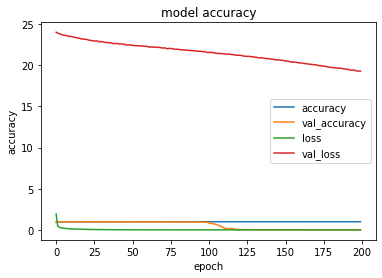

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [16]:
# def predict_NER(model, text, sequence_length):
#     x_list = list()
#     while len(text) > sequence_length:
#         x_list.append([i for i in text[:sequence_length]])
#         text = text[sequence_length:]        
#     x_list.append([i for i in text[:sequence_length]])
#     y_list = model.predict(x_list)
#     merge_list = list()
#     for i in y_list:
#         for j in i:
#             merge_list.append(j)
#     return merge_list

In [17]:
# def output_NER(article_id, text, y):
#     output = str()
#     flag = False
#     for i, j in enumerate(y):
#         if j != 'O':
#             if j[0] == 'B':
#                 start_position = i
#                 entity_type = j.split('-')[-1]
#                 flag = True
#         elif j == 'O' and flag == True:
#             end_position = i
#             flag = False
#             entity_text = text[start_position: end_position]
#             output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
#     return output

In [18]:
# for article_id, text in zip(df['article_id'], df['text']):
#     y = predict_NER(model, text, sequence_length)
#     output += output_NER(article_id, text, y)

In [19]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-12 19:06:32,716 [DEBUG] kashgari - predict seq_length: None, input: (2, 368, 29)


12/12 [==============================] - 1s 42ms/step


2020-12-12 19:06:35,922 [DEBUG] kashgari - predict output: (368, 29)
2020-12-12 19:06:35,922 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:35,924 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 33)


3/3 [==============================] - 0s 31ms/step


2020-12-12 19:06:38,947 [DEBUG] kashgari - predict output: (78, 33)
2020-12-12 19:06:38,948 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-12 19:06:38,951 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 29)


5/5 [==============================] - 0s 36ms/step


2020-12-12 19:06:39,202 [DEBUG] kashgari - predict output: (159, 29)
2020-12-12 19:06:39,203 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:39,209 [DEBUG] kashgari - predict seq_length: None, input: (2, 329, 28)


11/11 [==============================] - 0s 40ms/step


2020-12-12 19:06:42,423 [DEBUG] kashgari - predict output: (329, 28)
2020-12-12 19:06:42,424 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:42,428 [DEBUG] kashgari - predict seq_length: None, input: (2, 227, 29)


8/8 [==============================] - 0s 36ms/step


2020-12-12 19:06:42,781 [DEBUG] kashgari - predict output: (227, 29)
2020-12-12 19:06:42,782 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 6 4 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:42,789 [DEBUG] kashgari - predict seq_length: None, input: (2, 295, 26)


10/10 [==============================] - 0s 38ms/step


2020-12-12 19:06:46,080 [DEBUG] kashgari - predict output: (295, 26)
2020-12-12 19:06:46,081 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:46,084 [DEBUG] kashgari - predict seq_length: None, input: (2, 183, 25)


6/6 [==============================] - 0s 38ms/step


2020-12-12 19:06:49,305 [DEBUG] kashgari - predict output: (183, 25)
2020-12-12 19:06:49,306 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1 13 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 19:06:49,309 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 19)


4/4 [==============================] - 0s 28ms/step


2020-12-12 19:06:52,171 [DEBUG] kashgari - predict output: (126, 19)
2020-12-12 19:06:52,171 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:52,174 [DEBUG] kashgari - predict seq_length: None, input: (2, 117, 23)


4/4 [==============================] - 0s 32ms/step


2020-12-12 19:06:55,346 [DEBUG] kashgari - predict output: (117, 23)
2020-12-12 19:06:55,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:55,349 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 22)


3/3 [==============================] - 0s 27ms/step


2020-12-12 19:06:58,224 [DEBUG] kashgari - predict output: (91, 22)
2020-12-12 19:06:58,225 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:58,227 [DEBUG] kashgari - predict seq_length: None, input: (2, 63, 25)


2/2 [==============================] - 0s 23ms/step


2020-12-12 19:06:58,338 [DEBUG] kashgari - predict output: (63, 25)
2020-12-12 19:06:58,339 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:06:58,344 [DEBUG] kashgari - predict seq_length: None, input: (2, 259, 32)


9/9 [==============================] - 0s 43ms/step


2020-12-12 19:07:01,526 [DEBUG] kashgari - predict output: (259, 32)
2020-12-12 19:07:01,527 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  7  7  7]
 [ 0  1  1 ...  1  1  1]
 [ 0 10  7 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 19:07:01,530 [DEBUG] kashgari - predict seq_length: None, input: (2, 109, 20)


4/4 [==============================] - 0s 27ms/step


2020-12-12 19:07:04,634 [DEBUG] kashgari - predict output: (109, 20)
2020-12-12 19:07:04,635 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:04,638 [DEBUG] kashgari - predict seq_length: None, input: (2, 122, 22)


4/4 [==============================] - 0s 30ms/step


2020-12-12 19:07:04,817 [DEBUG] kashgari - predict output: (122, 22)
2020-12-12 19:07:04,817 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:04,820 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 40)


5/5 [==============================] - 0s 49ms/step


2020-12-12 19:07:07,865 [DEBUG] kashgari - predict output: (158, 40)
2020-12-12 19:07:07,866 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]]
2020-12-12 19:07:07,870 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 34)


7/7 [==============================] - 0s 45ms/step


2020-12-12 19:07:11,349 [DEBUG] kashgari - predict output: (218, 34)
2020-12-12 19:07:11,350 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:11,351 [DEBUG] kashgari - predict seq_length: None, input: (2, 103, 16)


4/4 [==============================] - 0s 24ms/step


2020-12-12 19:07:14,248 [DEBUG] kashgari - predict output: (103, 16)
2020-12-12 19:07:14,249 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]]
2020-12-12 19:07:14,255 [DEBUG] kashgari - predict seq_length: None, input: (2, 310, 40)


10/10 [==============================] - 1s 50ms/step


2020-12-12 19:07:14,844 [DEBUG] kashgari - predict output: (310, 40)
2020-12-12 19:07:14,845 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:14,846 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 22)


3/3 [==============================] - 0s 21ms/step


2020-12-12 19:07:14,964 [DEBUG] kashgari - predict output: (73, 22)
2020-12-12 19:07:14,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 6 4 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:14,974 [DEBUG] kashgari - predict seq_length: None, input: (2, 624, 50)


20/20 [==============================] - 1s 64ms/step


2020-12-12 19:07:19,218 [DEBUG] kashgari - predict output: (624, 50)
2020-12-12 19:07:19,219 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:19,223 [DEBUG] kashgari - predict seq_length: None, input: (2, 445, 35)


14/14 [==============================] - 1s 48ms/step


2020-12-12 19:07:22,743 [DEBUG] kashgari - predict output: (445, 35)
2020-12-12 19:07:22,743 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 6 ... 4 4 4]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:22,747 [DEBUG] kashgari - predict seq_length: None, input: (2, 357, 34)


12/12 [==============================] - 1s 42ms/step


2020-12-12 19:07:23,330 [DEBUG] kashgari - predict output: (357, 34)
2020-12-12 19:07:23,331 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:23,334 [DEBUG] kashgari - predict seq_length: None, input: (2, 328, 49)


11/11 [==============================] - 1s 59ms/step


2020-12-12 19:07:26,787 [DEBUG] kashgari - predict output: (328, 49)
2020-12-12 19:07:26,788 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:26,790 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 59)


5/5 [==============================] - 0s 58ms/step


2020-12-12 19:07:29,872 [DEBUG] kashgari - predict output: (133, 59)
2020-12-12 19:07:29,873 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:29,874 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 23)


5/5 [==============================] - 0s 28ms/step


2020-12-12 19:07:30,075 [DEBUG] kashgari - predict output: (129, 23)
2020-12-12 19:07:30,076 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:30,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 30)


5/5 [==============================] - 0s 37ms/step


2020-12-12 19:07:33,004 [DEBUG] kashgari - predict output: (131, 30)
2020-12-12 19:07:33,005 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:33,009 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 34)


8/8 [==============================] - 0s 42ms/step


2020-12-12 19:07:33,424 [DEBUG] kashgari - predict output: (234, 34)
2020-12-12 19:07:33,425 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:33,426 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 33)


3/3 [==============================] - 0s 27ms/step


2020-12-12 19:07:34,089 [DEBUG] kashgari - predict output: (79, 33)
2020-12-12 19:07:34,089 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:34,094 [DEBUG] kashgari - predict seq_length: None, input: (2, 260, 37)


9/9 [==============================] - 0s 48ms/step


2020-12-12 19:07:37,279 [DEBUG] kashgari - predict output: (260, 37)
2020-12-12 19:07:37,279 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:37,283 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 35)


8/8 [==============================] - 0s 43ms/step


2020-12-12 19:07:37,706 [DEBUG] kashgari - predict output: (255, 35)
2020-12-12 19:07:37,707 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:37,712 [DEBUG] kashgari - predict seq_length: None, input: (2, 175, 41)


6/6 [==============================] - 0s 49ms/step


2020-12-12 19:07:40,699 [DEBUG] kashgari - predict output: (175, 41)
2020-12-12 19:07:40,699 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:40,704 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 31)


6/6 [==============================] - 0s 41ms/step


2020-12-12 19:07:43,665 [DEBUG] kashgari - predict output: (189, 31)
2020-12-12 19:07:43,666 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:43,670 [DEBUG] kashgari - predict seq_length: None, input: (2, 292, 31)


10/10 [==============================] - 0s 38ms/step


2020-12-12 19:07:44,122 [DEBUG] kashgari - predict output: (292, 31)
2020-12-12 19:07:44,123 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:44,125 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 38)


4/4 [==============================] - 0s 38ms/step


2020-12-12 19:07:47,025 [DEBUG] kashgari - predict output: (97, 38)
2020-12-12 19:07:47,026 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:47,031 [DEBUG] kashgari - predict seq_length: None, input: (2, 351, 56)


11/11 [==============================] - 1s 69ms/step


2020-12-12 19:07:50,560 [DEBUG] kashgari - predict output: (351, 56)
2020-12-12 19:07:50,561 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:50,565 [DEBUG] kashgari - predict seq_length: None, input: (2, 297, 46)


10/10 [==============================] - 1s 60ms/step


2020-12-12 19:07:53,933 [DEBUG] kashgari - predict output: (297, 46)
2020-12-12 19:07:53,934 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:53,936 [DEBUG] kashgari - predict seq_length: None, input: (2, 136, 21)


5/5 [==============================] - 0s 29ms/step


2020-12-12 19:07:56,817 [DEBUG] kashgari - predict output: (136, 21)
2020-12-12 19:07:56,818 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:07:56,821 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 42)


4/4 [==============================] - 0s 45ms/step


2020-12-12 19:08:00,419 [DEBUG] kashgari - predict output: (115, 42)
2020-12-12 19:08:00,420 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:00,422 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 23)


3/3 [==============================] - 0s 24ms/step


2020-12-12 19:08:00,558 [DEBUG] kashgari - predict output: (89, 23)
2020-12-12 19:08:00,559 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:00,563 [DEBUG] kashgari - predict seq_length: None, input: (2, 251, 52)


8/8 [==============================] - 1s 63ms/step


2020-12-12 19:08:03,788 [DEBUG] kashgari - predict output: (251, 52)
2020-12-12 19:08:03,789 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:03,790 [DEBUG] kashgari - predict seq_length: None, input: (2, 153, 20)


5/5 [==============================] - 0s 27ms/step


2020-12-12 19:08:03,978 [DEBUG] kashgari - predict output: (153, 20)
2020-12-12 19:08:03,978 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  1  1  1]
 [ 0  1  1 ... 25 25 25]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 19:08:03,982 [DEBUG] kashgari - predict seq_length: None, input: (2, 169, 47)


6/6 [==============================] - 0s 53ms/step


2020-12-12 19:08:07,072 [DEBUG] kashgari - predict output: (169, 47)
2020-12-12 19:08:07,072 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:07,075 [DEBUG] kashgari - predict seq_length: None, input: (2, 324, 37)


11/11 [==============================] - 0s 45ms/step


2020-12-12 19:08:07,649 [DEBUG] kashgari - predict output: (324, 37)
2020-12-12 19:08:07,649 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 8 8 8]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:07,652 [DEBUG] kashgari - predict seq_length: None, input: (2, 157, 35)


5/5 [==============================] - 0s 39ms/step


2020-12-12 19:08:07,917 [DEBUG] kashgari - predict output: (157, 35)
2020-12-12 19:08:07,917 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:07,921 [DEBUG] kashgari - predict seq_length: None, input: (2, 191, 27)


6/6 [==============================] - 0s 40ms/step


2020-12-12 19:08:10,926 [DEBUG] kashgari - predict output: (191, 27)
2020-12-12 19:08:10,927 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:10,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 36)


4/4 [==============================] - 0s 40ms/step


2020-12-12 19:08:13,828 [DEBUG] kashgari - predict output: (115, 36)
2020-12-12 19:08:13,829 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:13,835 [DEBUG] kashgari - predict seq_length: None, input: (2, 529, 33)


17/17 [==============================] - 1s 44ms/step


2020-12-12 19:08:14,674 [DEBUG] kashgari - predict output: (529, 33)
2020-12-12 19:08:14,675 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:14,678 [DEBUG] kashgari - predict seq_length: None, input: (2, 217, 32)


7/7 [==============================] - 0s 39ms/step


2020-12-12 19:08:15,018 [DEBUG] kashgari - predict output: (217, 32)
2020-12-12 19:08:15,019 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:15,021 [DEBUG] kashgari - predict seq_length: None, input: (2, 186, 47)


6/6 [==============================] - 0s 52ms/step


2020-12-12 19:08:15,421 [DEBUG] kashgari - predict output: (186, 47)
2020-12-12 19:08:15,421 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:15,425 [DEBUG] kashgari - predict seq_length: None, input: (2, 410, 55)


13/13 [==============================] - 1s 68ms/step


2020-12-12 19:08:19,030 [DEBUG] kashgari - predict output: (410, 55)
2020-12-12 19:08:19,031 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:19,035 [DEBUG] kashgari - predict seq_length: None, input: (2, 347, 42)


11/11 [==============================] - 1s 51ms/step


2020-12-12 19:08:19,682 [DEBUG] kashgari - predict output: (347, 42)
2020-12-12 19:08:19,683 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:19,687 [DEBUG] kashgari - predict seq_length: None, input: (2, 524, 65)


17/17 [==============================] - 1s 77ms/step


2020-12-12 19:08:23,744 [DEBUG] kashgari - predict output: (524, 65)
2020-12-12 19:08:23,744 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:23,747 [DEBUG] kashgari - predict seq_length: None, input: (2, 182, 29)


6/6 [==============================] - 0s 36ms/step


2020-12-12 19:08:24,023 [DEBUG] kashgari - predict output: (182, 29)
2020-12-12 19:08:24,024 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:24,027 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 20)


6/6 [==============================] - 0s 27ms/step


2020-12-12 19:08:24,247 [DEBUG] kashgari - predict output: (163, 20)
2020-12-12 19:08:24,247 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:24,249 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 19)


4/4 [==============================] - 0s 23ms/step


2020-12-12 19:08:24,394 [DEBUG] kashgari - predict output: (97, 19)
2020-12-12 19:08:24,395 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:24,399 [DEBUG] kashgari - predict seq_length: None, input: (2, 189, 21)


6/6 [==============================] - 0s 29ms/step


2020-12-12 19:08:24,630 [DEBUG] kashgari - predict output: (189, 21)
2020-12-12 19:08:24,631 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:24,636 [DEBUG] kashgari - predict seq_length: None, input: (2, 320, 25)


10/10 [==============================] - 0s 32ms/step


2020-12-12 19:08:26,840 [DEBUG] kashgari - predict output: (320, 25)
2020-12-12 19:08:26,840 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:26,843 [DEBUG] kashgari - predict seq_length: None, input: (2, 301, 20)


10/10 [==============================] - 0s 29ms/step


2020-12-12 19:08:27,191 [DEBUG] kashgari - predict output: (301, 20)
2020-12-12 19:08:27,192 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:27,195 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 35)


3/3 [==============================] - 0s 29ms/step


2020-12-12 19:08:27,352 [DEBUG] kashgari - predict output: (82, 35)
2020-12-12 19:08:27,352 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:27,356 [DEBUG] kashgari - predict seq_length: None, input: (2, 192, 37)


6/6 [==============================] - 0s 39ms/step


2020-12-12 19:08:29,530 [DEBUG] kashgari - predict output: (192, 37)
2020-12-12 19:08:29,531 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 6 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:29,535 [DEBUG] kashgari - predict seq_length: None, input: (2, 264, 48)


9/9 [==============================] - 1s 57ms/step


2020-12-12 19:08:33,002 [DEBUG] kashgari - predict output: (264, 48)
2020-12-12 19:08:33,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:33,006 [DEBUG] kashgari - predict seq_length: None, input: (2, 247, 43)


8/8 [==============================] - 0s 52ms/step


2020-12-12 19:08:36,356 [DEBUG] kashgari - predict output: (247, 43)
2020-12-12 19:08:36,357 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:36,359 [DEBUG] kashgari - predict seq_length: None, input: (2, 120, 21)


4/4 [==============================] - 0s 26ms/step


2020-12-12 19:08:36,516 [DEBUG] kashgari - predict output: (120, 21)
2020-12-12 19:08:36,517 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 21 21 21]
 [ 0  1  1 ...  1  1  1]
 [ 0  6  4 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  0 ...  0  0  0]]
2020-12-12 19:08:36,518 [DEBUG] kashgari - predict seq_length: None, input: (2, 49, 21)


2/2 [==============================] - 0s 15ms/step


2020-12-12 19:08:36,603 [DEBUG] kashgari - predict output: (49, 21)
2020-12-12 19:08:36,604 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:36,606 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 32)


4/4 [==============================] - 0s 31ms/step


2020-12-12 19:08:36,795 [DEBUG] kashgari - predict output: (104, 32)
2020-12-12 19:08:36,796 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:36,799 [DEBUG] kashgari - predict seq_length: None, input: (2, 190, 33)


6/6 [==============================] - 0s 40ms/step


2020-12-12 19:08:37,108 [DEBUG] kashgari - predict output: (190, 33)
2020-12-12 19:08:37,109 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:37,111 [DEBUG] kashgari - predict seq_length: None, input: (2, 79, 25)


3/3 [==============================] - 0s 24ms/step


2020-12-12 19:08:37,240 [DEBUG] kashgari - predict output: (79, 25)
2020-12-12 19:08:37,241 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:37,244 [DEBUG] kashgari - predict seq_length: None, input: (2, 162, 39)


6/6 [==============================] - 0s 46ms/step


2020-12-12 19:08:41,132 [DEBUG] kashgari - predict output: (162, 39)
2020-12-12 19:08:41,133 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:41,135 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 23)


3/3 [==============================] - 0s 25ms/step


2020-12-12 19:08:43,366 [DEBUG] kashgari - predict output: (96, 23)
2020-12-12 19:08:43,367 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]
2020-12-12 19:08:43,371 [DEBUG] kashgari - predict seq_length: None, input: (2, 197, 40)


7/7 [==============================] - 0s 45ms/step


2020-12-12 19:08:43,776 [DEBUG] kashgari - predict output: (197, 40)
2020-12-12 19:08:43,777 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]]


In [20]:
print(output_str)

article_id	start_position	end_position	entity_text	entity_type
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	409	411	4點	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	817	819	晚上	time
0	1168	1172	7月21	time
0	1571	1574	10多	time
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2226	2228	3天	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2767	2770	皇后區	location
0	2774	2777	皇后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	111	114	6.0	med_exam
2	279	282	2年前	time
2	496	498	泰國	location
2	563	566	光華路	location
2	571	574	光華路	location
2	1096	1098	半年	time
2	1114	1116	半年	time
2	1118	1120	半年	time
2	1139	1141	爸爸	family


In [21]:
output_path = 'output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)